In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
#!pip install pyLDAvis

In [8]:
df = pd.read_csv('../aftercovid.csv')

df["Year"] = df["Date"].str.split("-").str[2]

In [9]:
df["Year"].value_counts()

20    7310
21    5721
22    2427
Name: Year, dtype: int64

In [10]:

df_assigned = df

In [11]:
df_assigned = df_assigned.reset_index(drop=True)

# Data cleaning

In [12]:
# Remove non-English words

# remove punc 
df_assigned['clean_text']  = df_assigned['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: x.lower())
# tokenize
df_assigned['clean_text']  = [word_tokenize(row) for row in df_assigned['text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use',"lah","haha","#","%"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df_assigned['clean_text']  = df_assigned['clean_text'].apply(lambda x: remove_stopwords(x))


In [13]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df_assigned['clean_text'] = df_assigned['clean_text'].apply(lambda x: lemmatization(x))


df_assigned.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,26-Nov-20,A freehold semi-detached house at 61 Jalan Kel...,20,Nov,"[house, market, estate, marketing, agent, sale...",freehold semi detached house 61 jalan kelawar ...,2020-11-26
1,23-Nov-20,"A 4,822 sq ft unit at luxury condo, Nassim Par...",20,Nov,"[sq, ft, unit, luxury, market, price, tag, psf...",4 822 sq ft unit luxury nassim park residences...,2020-11-23
2,22-Nov-20,vinz said:\r\nWrote to HDB in OCT 2020 to get ...,20,Nov,"[confirmation, eligibility, resale, grant, key...",vinz wrote hdb oct 2020 get confirmation eligi...,2020-11-22
3,18-Nov-20,Wrote to HDB in OCT 2020 to get a confirmation...,20,Nov,"[confirmation, eligibility, resale, grant, key...",wrote hdb oct 2020 get confirmation eligibilit...,2020-11-18
4,29-Oct-20,Depends on if you need the space or not ?\r\nT...,20,Oct,"[space, rule, year, usage, loan, buyer, year, ...",depends need space rules changed last year usa...,2020-10-29


In [14]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df_assigned['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


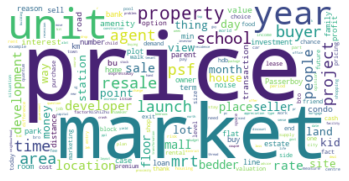

In [15]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<AxesSubplot:xlabel='frequency', ylabel='pairs'>

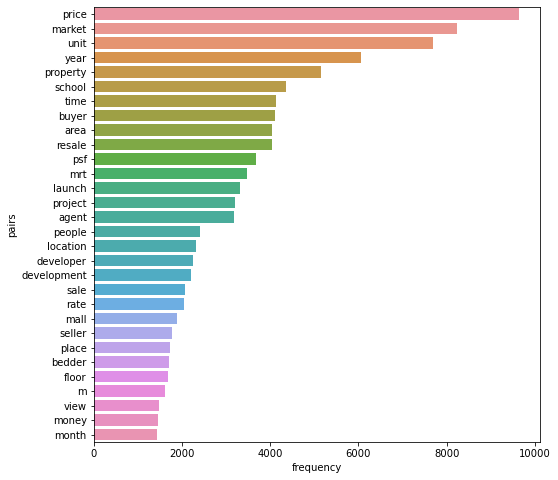

In [16]:
new_tokens = []
for i in df_assigned["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [17]:
data_lemmatized = df_assigned['clean_text'].tolist()
print(data_lemmatized[:3])

[['house', 'market', 'estate', 'marketing', 'agent', 'sale', 'storey', 'house', 'plot', 'sq', 'ft', 'metre', 'frontage', 'price', 'translate', 'land', 'rate', 'psf', 'property', 'ne', 'arezone', 'utm_medium=', 'utm_campaign'], ['sq', 'ft', 'unit', 'luxury', 'market', 'price', 'tag', 'psf', 'property', 'ne', 'arezone', 'utm_medium=', 'utm_campaign'], ['confirmation', 'eligibility', 'resale', 'grant', 'key', 'resale', 'grant', 'dong', 'conclusion', 'email', 'couple', 'resale', 'grant', 'year', 'completion', 'date', 'reason', 'course', 'flat', 'forum', 'discussion', 'matter', 'grant', 'resale', 'flat', 'application', 'place', 'year', 'doubt', 'matter', 'part', 'question', 'reply', 'enquiry', 'oct', 'reply', 'eligibility', 'condition', 'applicant', 'occupier', 'reply', 'thing', 'owner', 'resale', 'flat', 'market', 'fulfil', 'minimum', 'occupation', 'period', 'year', 'wish', 'expiry', 'year', 'resale', 'flat', 'year', 'period', 'date', 'possession', 'resale', 'flat', 'period', 'resale', 'co

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [19]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'agent'), (1, 'arezone'), (2, 'estate'), (3, 'frontage'), (4, 'ft'), (5, 'house'), (6, 'land'), (7, 'market'), (8, 'marketing'), (9, 'metre'), (10, 'ne'), (11, 'plot'), (12, 'price'), (13, 'property'), (14, 'psf'), (15, 'rate'), (16, 'sale'), (17, 'sq'), (18, 'storey'), (19, 'translate'), (20, 'utm_campaign'), (21, 'utm_medium='), (22, 'luxury'), (23, 'tag'), (24, 'unit'), (25, 'applicant'), (26, 'application'), (27, 'completion'), (28, 'computation'), (29, 'conclusion'), (30, 'condition'), (31, 'confirmation'), (32, 'couple'), (33, 'course'), (34, 'date'), (35, 'discussion'), (36, 'dong'), (37, 'doubt'), (38, 'eligibility'), (39, 'email'), (40, 'enquiry'), (41, 'expiry'), (42, 'flat'), (43, 'forum'), (44, 'fulfil'), (45, 'grant'), (46, 'key'), (47, 'matter'), (48, 'minimum'), (49, 'occupation')]

Total Vocabulary Size: 8181


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [35]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [36]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5057211554138503
Perplexity Score:  -6.8931655546556705

topic number:  3
Coherence Score:  0.5589368875956297
Perplexity Score:  -6.845198797182607

topic number:  4
Coherence Score:  0.5756311418706668
Perplexity Score:  -6.860694239005203

topic number:  5
Coherence Score:  0.5476246683611857
Perplexity Score:  -6.859540118478317

topic number:  6
Coherence Score:  0.5865756227801412
Perplexity Score:  -6.888123003322275

topic number:  7
Coherence Score:  0.5731689258180529
Perplexity Score:  -6.91083872198316

topic number:  8
Coherence Score:  0.5894024053109077
Perplexity Score:  -6.911746558715645

topic number:  9
Coherence Score:  0.5795505207346587
Perplexity Score:  -6.978708274533226

topic number:  10
Coherence Score:  0.5522966034538751
Perplexity Score:  -7.045348692650233

topic number:  11
Coherence Score:  0.5306376717763097
Perplexity Score:  -7.232804258908122

topic number:  12
Coherence Score:  0.5466243785570934
Perplexity Sc

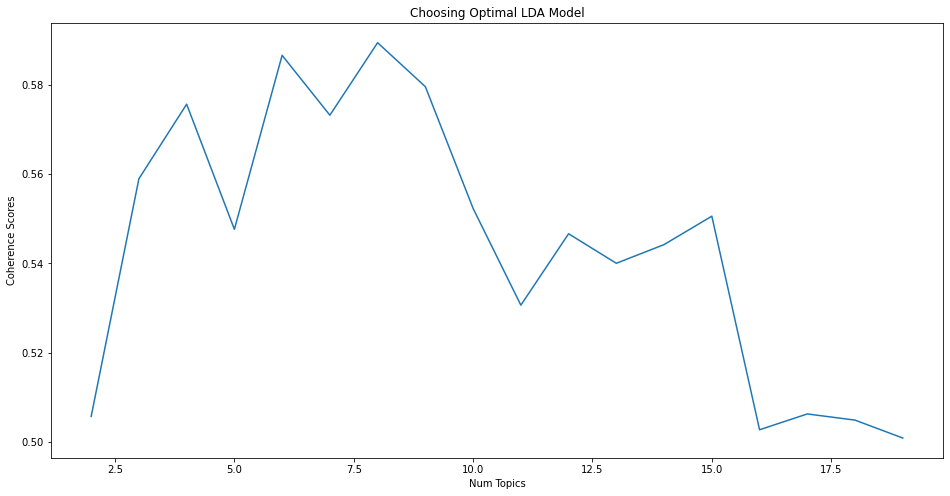

In [37]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [23]:
ntopics_des_name = 10

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [24]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.061*"market" + 0.057*"property" + 0.036*"price" + 0.026*"year" + '
  '0.023*"time" + 0.017*"people" + 0.016*"resale" + 0.015*"money" + '
  '0.010*"buyer" + 0.009*"investment"'),
 (1,
  '0.153*"school" + 0.042*"kid" + 0.037*"km" + 0.029*"parent" + 0.019*"family" '
  '+ 0.018*"child" + 0.015*"place" + 0.012*"year" + 0.011*"student" + '
  '0.010*"house"'),
 (2,
  '0.066*"agent" + 0.044*"price" + 0.039*"seller" + 0.035*"buyer" + '
  '0.030*"market" + 0.027*"unit" + 0.018*"valuation" + 0.014*"property" + '
  '0.014*"time" + 0.013*"resale"'),
 (3,
  '0.034*"area" + 0.033*"mrt" + 0.031*"bus" + 0.025*"noise" + 0.024*"min" + '
  '0.021*"road" + 0.019*"expressway" + 0.016*"park" + 0.016*"distance" + '
  '0.015*"line"'),
 (4,
  '0.085*"unit" + 0.052*"bedder" + 0.044*"floor" + 0.026*"m" + 0.015*"view" + '
  '0.014*"pool" + 0.012*"bedroom" + 0.012*"layout" + 0.011*"room" + '
  '0.011*"size"'),
 (5,
  '0.100*"site" + 0.070*"plot" + 0.055*"land" + 0.023*"bid" + '
  '0.020*"developer" + 0.01

In [25]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [26]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df_assigned)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [27]:
df_assigned['Topic'] = topic_num

In [28]:
df_assigned

,Date,text,Year,Month,clean_text,join_clean_text,real_Date,Topic
0,26-Nov-20,A freehold semi-detached house at 61 Jalan Kel...,20,Nov,"[house, market, estate, marketing, agent, sale...",freehold semi detached house 61 jalan kelawar ...,2020-11-26,"[7, 9, 2, 5]"
1,23-Nov-20,"A 4,822 sq ft unit at luxury condo, Nassim Par...",20,Nov,"[sq, ft, unit, luxury, market, price, tag, psf...",4 822 sq ft unit luxury nassim park residences...,2020-11-23,[7]
2,22-Nov-20,vinz said:\r\nWrote to HDB in OCT 2020 to get ...,20,Nov,"[confirmation, eligibility, resale, grant, key...",vinz wrote hdb oct 2020 get confirmation eligi...,2020-11-22,"[2, 9]"
3,18-Nov-20,Wrote to HDB in OCT 2020 to get a confirmation...,20,Nov,"[confirmation, eligibility, resale, grant, key...",wrote hdb oct 2020 get confirmation eligibilit...,2020-11-18,"[2, 9]"
4,29-Oct-20,Depends on if you need the space or not ?\r\nT...,20,Oct,"[space, rule, year, usage, loan, buyer, year, ...",depends need space rules changed last year usa...,2020-10-29,"[9, 2, 4, 1]"
...,...,...,...,...,...,...,...,...
15453,30-Nov-20,A four-storey shophouse at 11 New Bridge Road ...,20,Nov,"[storey, shophouse, market, marketing, agent, ...",four storey shophouse 11 new bridge road marke...,2020-11-30,"[7, 4, 2]"
15454,29-Nov-20,"The price of 1 bedder in D19 for example, pric...",20,Nov,"[price, bedder, example, 850k, eg, project, si...",price 1 bedder d19 example price around 750 85...,2020-11-29,"[4, 7, 8]"
15455,25-Nov-20,angrymonster said:\n324k to 397k\n\nStack 123 ...,20,Nov,"[324k, 397k, floor, floor, 397k]",angrymonster 324k 397k stack 123 top floor sta...,2020-11-25,"[4, 0, 1, 2, 3, 5, 6, 7, 8, 9]"
15456,25-Nov-20,Is it true that top floor units are taller in ...,20,Nov,"[floor, unit, height, floor, plan, brochure, b...",true top floor units taller height floor plan ...,2020-11-25,"[4, 5, 7]"


In [29]:
des_name_final = df_assigned[['Date', 'text', 'clean_text', 'Topic']]
des_name_final.head()

,Date,text,clean_text,Topic
0,26-Nov-20,A freehold semi-detached house at 61 Jalan Kel...,"[house, market, estate, marketing, agent, sale...","[7, 9, 2, 5]"
1,23-Nov-20,"A 4,822 sq ft unit at luxury condo, Nassim Par...","[sq, ft, unit, luxury, market, price, tag, psf...",[7]
2,22-Nov-20,vinz said:\r\nWrote to HDB in OCT 2020 to get ...,"[confirmation, eligibility, resale, grant, key...","[2, 9]"
3,18-Nov-20,Wrote to HDB in OCT 2020 to get a confirmation...,"[confirmation, eligibility, resale, grant, key...","[2, 9]"
4,29-Oct-20,Depends on if you need the space or not ?\r\nT...,"[space, rule, year, usage, loan, buyer, year, ...","[9, 2, 4, 1]"


In [30]:
# des_name_final.to_csv('description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [31]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.023020173405799
Coherence Score:  0.5410219888400751


## Visualisation

In [32]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.118626  0.042489       1        1  19.397410
0     -0.193617  0.030989       2        1  18.221686
2     -0.221284  0.032930       3        1  11.701517
3      0.228399  0.150365       4        1  10.215332
4      0.007367  0.027767       5        1   9.228103
9     -0.171491  0.011601       6        1   7.935862
6      0.171854  0.167078       7        1   7.922751
1      0.017203 -0.004530       8        1   7.627508
5      0.079057 -0.404600       9        1   3.993116
8      0.201138 -0.054090      10        1   3.756713, topic_info=        Term         Freq        Total Category  logprob  loglift
222   school  4459.000000  4459.000000  Default  30.0000  30.0000
24      unit  7581.000000  7581.000000  Default  29.0000  29.0000
0      agent  2966.000000  2966.000000  Default  28.0000  28.0000
14       psf  3642.000000  3642.000000  Default  27.0000  27.0000
462      mrt  3560.000000  3560.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1109    abit    70.290659   158.307889  Topic10  -5.3219   2.4697
6       land    96.803299  1575.229035  Topic10  -5.0018   0.4922
65    people    91.944331  2415.067589  Topic10  -5.0533   0.0133
151     case    82.150607   849.138762  Topic10  -5.1659   0.9460
1789    hype    69.689600   154.942422  Topic10  -5.3304   2.4826

[625 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2998      9  0.968287        13xx
1165      5  0.988031        150k
1948      1  0.995203        15xx
1839      1  0.990765        16xx
2208      1  0.987685        17xx
...     ...       ...         ...
63       10  0.007273        year
2367      8  0.977322      yishun
4417      6  0.978696          yo
2607     10  0.991158  zetrio2006
4326      6  0.978770           |

[1118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 3, 4, 5, 10, 7, 2, 6, 9])

## Word Count of Topic Keywords

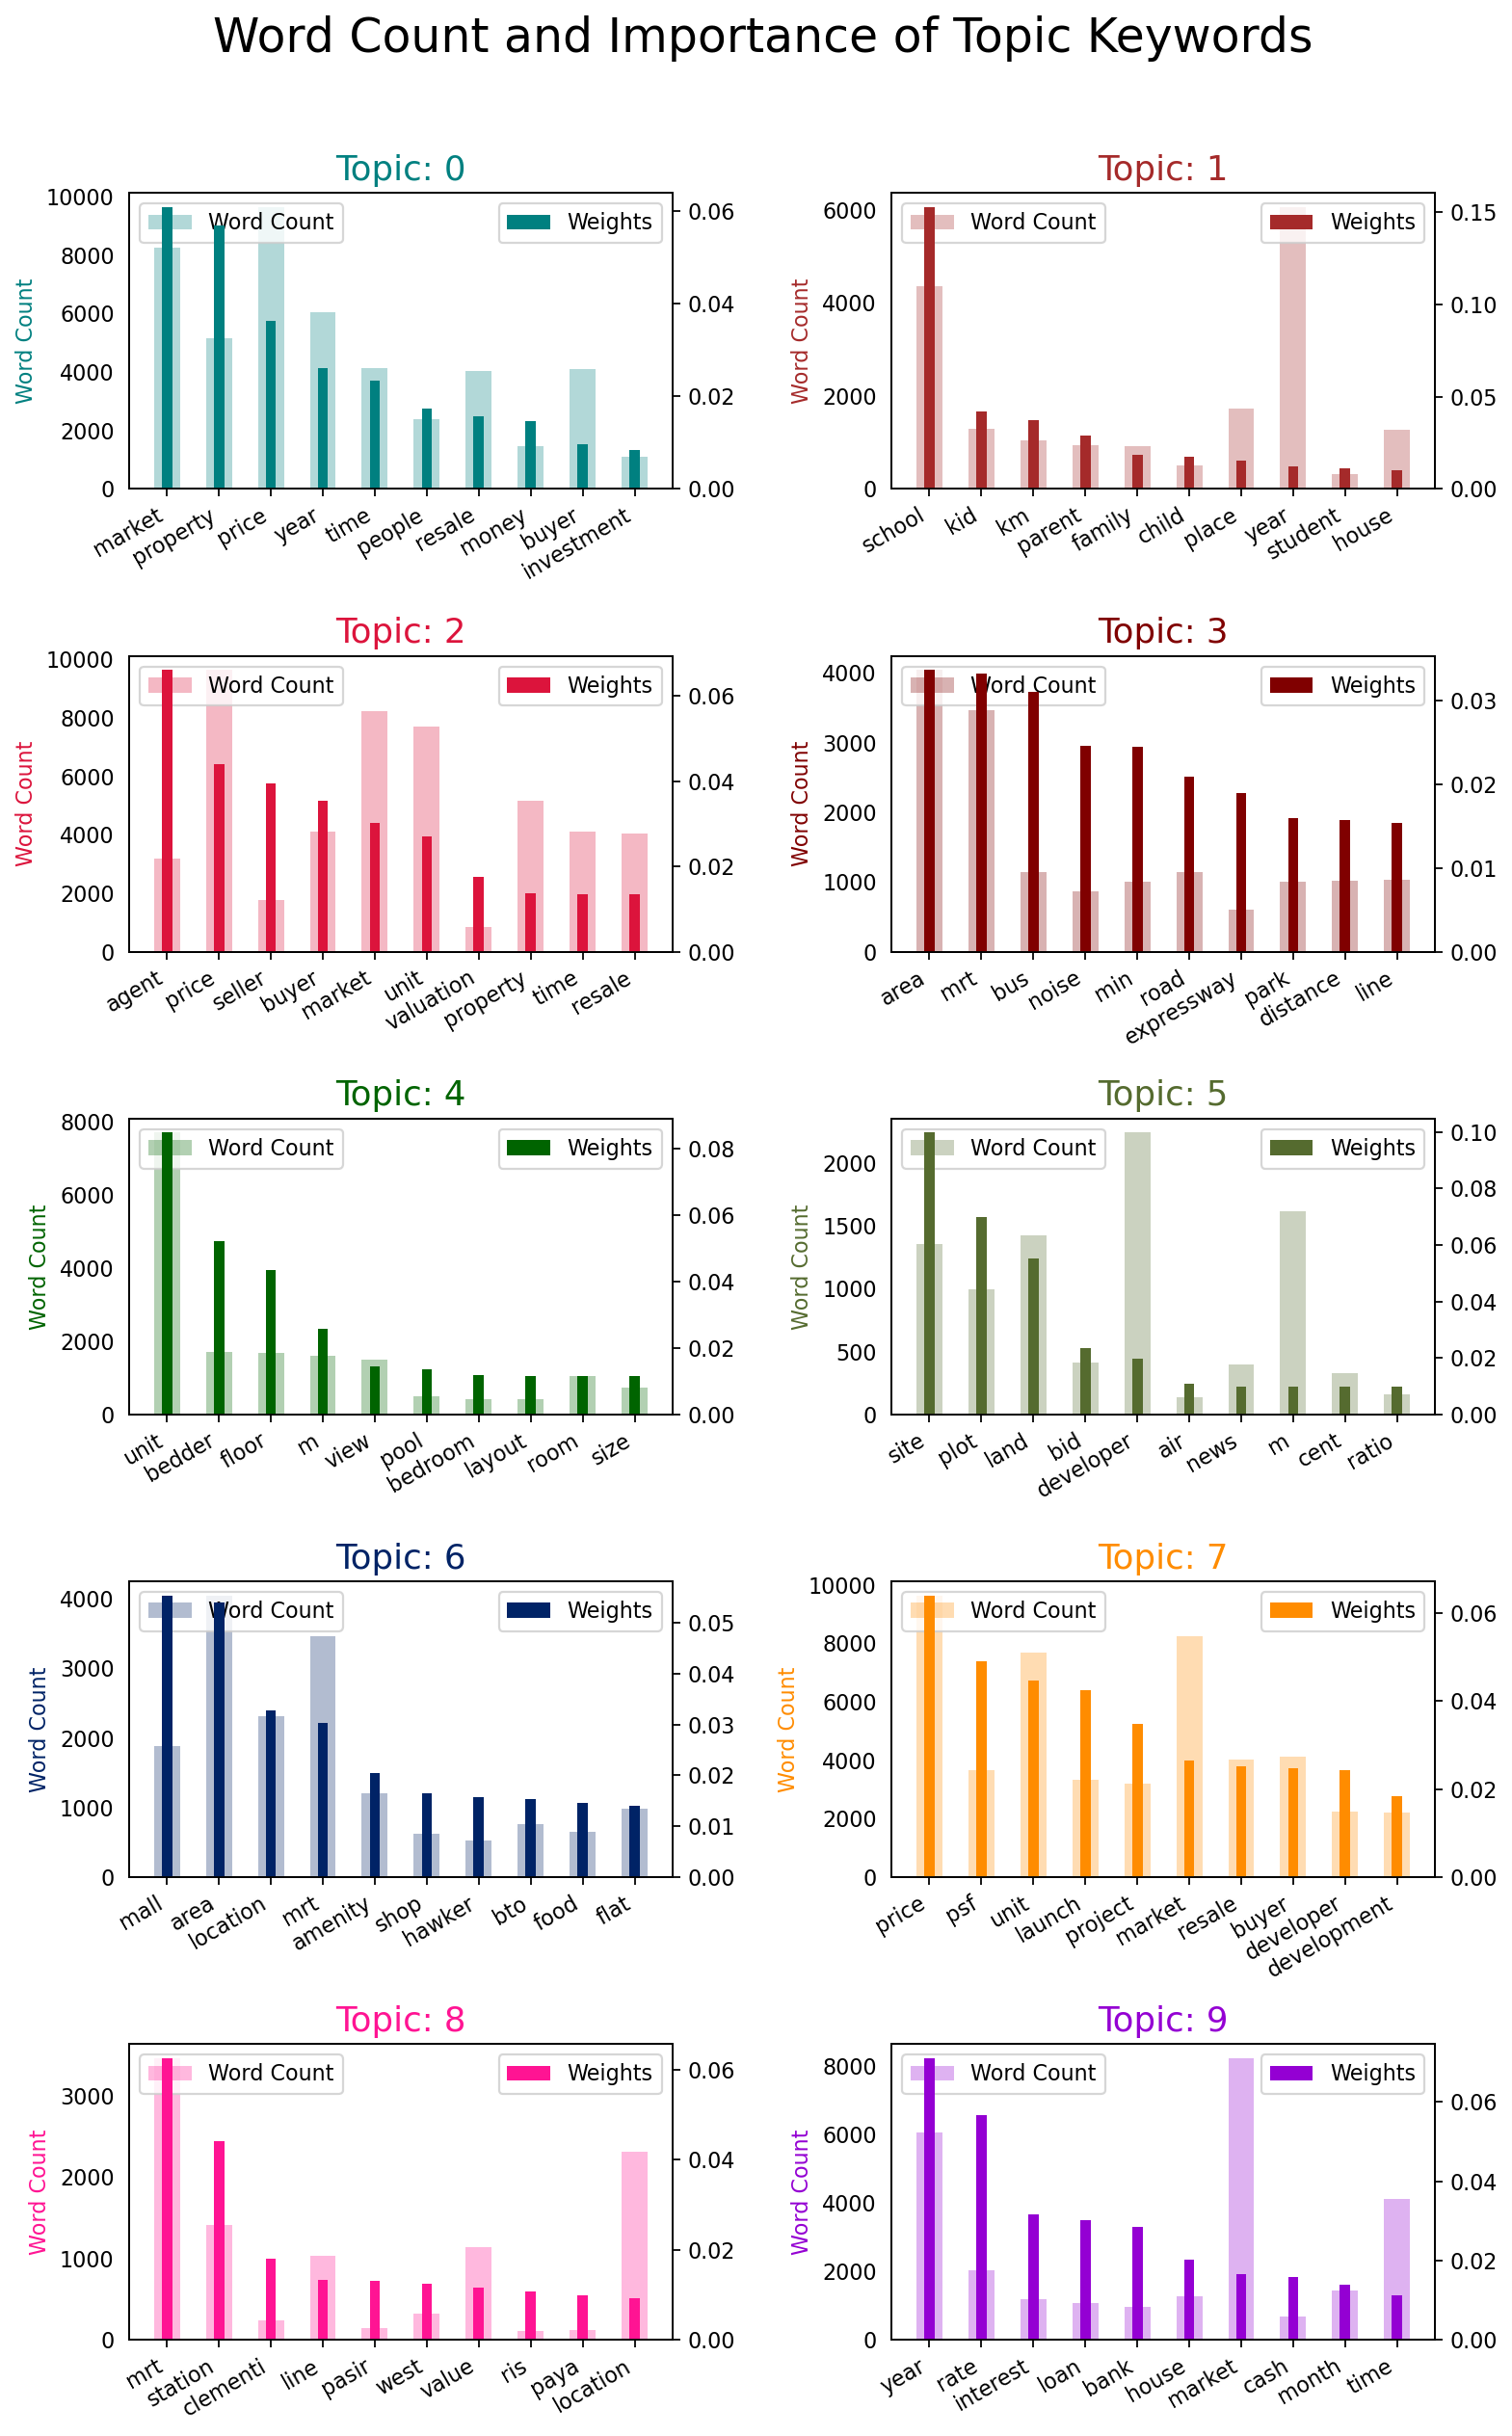

In [34]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
